_This notebook contains code and comments from Section 7.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 7.4	Case Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# # Load the original UCI data set, drop some columns and save it for this Case Study
# data = pd.read_csv('./data/ch07/bikesharing-hour.csv')
# data = data.drop(['dteday', 'instant', 'yr', 'registered', 'cnt'], axis=1)
# data.to_csv('./data/ch07/bikesharing.csv', index=False)

### 7.4.1 Preprocessing
Load the data set and preprocess it

In [3]:
data = pd.read_csv('./data/ch07/bikesharing.csv')
pd.options.display.float_format = '{:,.3f}'.format
data.describe()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual
count,"17,379.000","17,379.000","17,379.000","17,379.000","17,379.000","17,379.000","17,379.000","17,379.000","17,379.000","17,379.000","17,379.000","17,379.000"
mean,2.502,6.538,11.547,0.029,3.004,0.683,1.425,0.497,0.476,0.627,0.190,35.676
std,1.107,3.439,6.914,0.167,2.006,0.465,0.639,0.193,0.172,0.193,0.122,49.305
min,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.020,0.000,0.000,0.000,0.000
25%,2.000,4.000,6.000,0.000,1.000,0.000,1.000,0.340,0.333,0.480,0.104,4.000
50%,3.000,7.000,12.000,0.000,3.000,1.000,1.000,0.500,0.485,0.630,0.194,17.000
75%,3.000,10.000,18.000,0.000,5.000,1.000,2.000,0.660,0.621,0.780,0.254,48.000
max,4.000,12.000,23.000,1.000,6.000,1.000,4.000,1.000,1.000,1.000,0.851,367.000


**Listing 7.8**: Preprocessing the Bike Rental Data Set

In [4]:
# Get indices for the features and labels
labels = data.columns.get_loc('casual')
features = np.setdiff1d(np.arange(0, len(data.columns), 1), labels)

# Split into train and test sets
from sklearn.model_selection import train_test_split
trn, tst = train_test_split(data, test_size=0.2, random_state=42)
Xtrn, ytrn = trn.values[:, features], trn.values[:, labels]
Xtst, ytst = tst.values[:, features], tst.values[:, labels]

# Normalize the data
from sklearn.preprocessing import StandardScaler
preprocessor = StandardScaler().fit(Xtrn)
Xtrn, Xtst = preprocessor.transform(Xtrn), preprocessor.transform(Xtst)

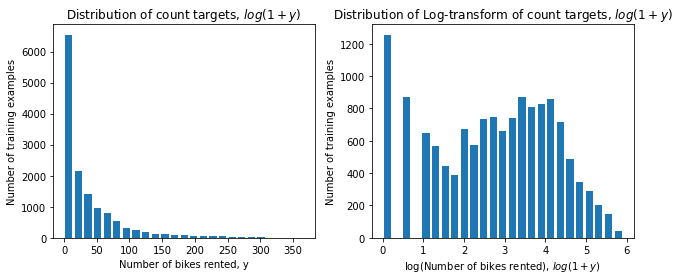

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

counts, bins = np.histogram(ytrn, bins=25)
ax[0].hist(bins[:-1], bins, weights=counts, rwidth=0.75);
ax[0].set_title('Distribution of count targets, $log(1 + y)$');
ax[0].set_xlabel('Number of bikes rented, y');
ax[0].set_ylabel('Number of training examples');

counts, bins = np.histogram(np.log(1 + ytrn), bins=25)
ax[1].hist(bins[:-1], bins, weights=counts, rwidth=0.75);
ax[1].set_title('Distribution of Log-transform of count targets, $log(1 + y)$');
ax[1].set_xlabel('log(Number of bikes rented), $log(1 + y)$');
ax[1].set_ylabel('Number of training examples');

fig.tight_layout()
pngFile = './figures/CH07_F13_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 7.4.2	Generalized Linear Models and Stacking

**Listing 7.9**: Training GLMs for Bike Rental Prediction

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, PoissonRegressor, TweedieRegressor

parameters = {'GLM: Linear': {'alpha': 10 ** np.arange(-4., 1.)},
              'GLM: Poisson': {'alpha': 10 ** np.arange(-4., 1.)},
              'GLM: Tweedie': {'alpha': 10 ** np.arange(-4., 1.), 
                               'power': np.linspace(1.1, 1.9, num=5)}}

glms = {'GLM: Linear': Ridge(),
        'GLM: Poisson': PoissonRegressor(max_iter=1000), 
        'GLM: Tweedie': TweedieRegressor(max_iter=1000)}

best_glms = {}
results = pd.DataFrame()

for glm_type, glm in glms.items():
    param_tuner = GridSearchCV(glm, parameters[glm_type], cv=5, refit=True, verbose=2)
    param_tuner.fit(Xtrn, ytrn)
    
    best_glms[glm_type] = param_tuner.best_estimator_
    ypred_trn = best_glms[glm_type].predict(Xtrn)
    ypred_tst = best_glms[glm_type].predict(Xtst)
    
    res = {'Method': glm_type, 
            'Train MSE': mean_squared_error(ytrn, ypred_trn),
            'Train MAE': mean_absolute_error(ytrn, ypred_trn), 
            'Train R2': r2_score(ytrn, ypred_trn), 
            'Test MSE': mean_squared_error(ytst, ypred_tst),
            'Test MAE': mean_absolute_error(ytst, ypred_tst),
            'Test R2': r2_score(ytst, ypred_tst)}
    results = results.append(res, ignore_index=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ........................................

[CV] END ..............................alpha=0.01, power=1.1; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.1; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.1; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.1; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.3; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.3; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.3; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.3; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.3; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.5; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.5; total time=   0.0s
[CV] END ..............................alpha=0.01, power=1.5; total time=   0.0s
[CV] END ...................

In [7]:
results

,Method,Test MAE,Test MSE,Test R2,Train MAE,Train MSE,Train R2
0,GLM: Linear,23.985,"1,270.174",0.447,24.964,"1,368.677",0.444
1,GLM: Poisson,20.641,"1,228.898",0.465,21.726,"1,354.006",0.450
2,GLM: Tweedie,20.661,"1,254.304",0.454,21.755,"1,383.374",0.438


**Listing 7.10**: Stacking GLMs for Bike Rental Prediction

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

base_estimators = list(best_glms.items())
meta_learner = MLPRegressor(hidden_layer_sizes=(25, 25, 25), max_iter=1000, activation='relu')
stack = StackingRegressor(base_estimators, final_estimator=meta_learner)
stack.fit(Xtrn, ytrn)

ypred_trn = stack.predict(Xtrn)
ypred_tst = stack.predict(Xtst)
    
res = {'Method': 'GLM Stack', 
        'Train MSE': mean_squared_error(ytrn, ypred_trn),
        'Train MAE': mean_absolute_error(ytrn, ypred_trn), 
        'Train R2': r2_score(ytrn, ypred_trn), 
        'Test MSE': mean_squared_error(ytst, ypred_tst),
        'Test MAE': mean_absolute_error(ytst, ypred_tst),
        'Test R2': r2_score(ytst, ypred_tst)}
results = results.append(res, ignore_index=True)

In [9]:
results

,Method,Test MAE,Test MSE,Test R2,Train MAE,Train MSE,Train R2
0,GLM: Linear,23.985,"1,270.174",0.447,24.964,"1,368.677",0.444
1,GLM: Poisson,20.641,"1,228.898",0.465,21.726,"1,354.006",0.450
2,GLM: Tweedie,20.661,"1,254.304",0.454,21.755,"1,383.374",0.438
3,GLM Stack,18.402,930.013,0.595,19.155,974.801,0.604


---
### 7.4.2 Random Forest and ExtraTrees

**Listing 7.11**: Random Forest and ExtraTrees for Bike Rental Prediction

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

parameters = {'n_estimators': np.arange(200, 600, step=100), 
              'max_depth': np.arange(4, 7, step=1)}

print(parameters)
ensembles = {'Random Forest': RandomForestRegressor(criterion='mse'),
             'ExtraTrees': ExtraTreesRegressor(criterion='mse')}
             
for ens_type, ensemble in ensembles.items():
    param_tuner = GridSearchCV(ensemble, parameters, cv=5, refit=True, verbose=2)
    param_tuner.fit(Xtrn, ytrn)
        
    ypred_trn = param_tuner.best_estimator_.predict(Xtrn)
    ypred_tst = param_tuner.best_estimator_.predict(Xtst)
    
    res = {'Method': ens_type, 
            'Train MSE': mean_squared_error(ytrn, ypred_trn),
            'Train MAE': mean_absolute_error(ytrn, ypred_trn), 
            'Train R2': r2_score(ytrn, ypred_trn), 
            'Test MSE': mean_squared_error(ytst, ypred_tst),
            'Test MAE': mean_absolute_error(ytst, ypred_tst),
            'Test R2': r2_score(ytst, ypred_tst)}
    results = results.append(res, ignore_index=True)

{'n_estimators': array([200, 300, 400, 500]), 'max_depth': array([4, 5, 6])}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.5s
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.6s
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.6s
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.5s
[CV] END ......................max_depth=4, n_estimators=200; total time=   1.6s
[CV] END ......................max_depth=4, n_estimators=300; total time=   2.4s
[CV] END ......................max_depth=4, n_estimators=300; total time=   2.3s
[CV] END ......................max_depth=4, n_estimators=300; total time=   2.5s
[CV] END ......................max_depth=4, n_estimators=300; total time=   2.3s
[CV] END ......................max_depth=4, n_estimators=300; total time=   2.3s
[CV] END ......................max_depth=4, n_estima

[CV] END ......................max_depth=5, n_estimators=500; total time=   2.4s
[CV] END ......................max_depth=6, n_estimators=200; total time=   1.0s
[CV] END ......................max_depth=6, n_estimators=200; total time=   1.0s
[CV] END ......................max_depth=6, n_estimators=200; total time=   1.1s
[CV] END ......................max_depth=6, n_estimators=200; total time=   1.1s
[CV] END ......................max_depth=6, n_estimators=200; total time=   1.1s
[CV] END ......................max_depth=6, n_estimators=300; total time=   1.6s
[CV] END ......................max_depth=6, n_estimators=300; total time=   1.5s
[CV] END ......................max_depth=6, n_estimators=300; total time=   1.5s
[CV] END ......................max_depth=6, n_estimators=300; total time=   1.6s
[CV] END ......................max_depth=6, n_estimators=300; total time=   1.6s
[CV] END ......................max_depth=6, n_estimators=400; total time=   2.2s
[CV] END ...................

In [11]:
results

,Method,Test MAE,Test MSE,Test R2,Train MAE,Train MSE,Train R2
0,GLM: Linear,23.985,"1,270.174",0.447,24.964,"1,368.677",0.444
1,GLM: Poisson,20.641,"1,228.898",0.465,21.726,"1,354.006",0.450
2,GLM: Tweedie,20.661,"1,254.304",0.454,21.755,"1,383.374",0.438
3,GLM Stack,18.402,930.013,0.595,19.155,974.801,0.604
4,Random Forest,12.279,488.183,0.788,12.529,496.213,0.799
5,ExtraTrees,13.657,556.447,0.758,13.865,563.810,0.771


### 7.4.3 Gradient Boosting Models

**Note**: When executed, the parameter selection below occassionally produces ``FitFailedWarning`` for some parameter combinations. This is a known bug in xgboost's implementation of the ``poisson-nloglik`` evaluation metric, and can be ignored for now.

**Listing 7.12**: XGBoost for Bike Rental Prediction

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

parameters = {'max_depth': np.arange(2, 7, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8],
              'reg_alpha': [0, 0.01, 0.1, 1, 10],
              'reg_lambda': [0, 0.01, 0.1, 1e-1, 1, 10]}
print(parameters)

ensembles = {'XGB: Squared Error': XGBRegressor(objective='reg:squarederror'),
             'XGB: Pseudo Huber': XGBRegressor(objective='reg:pseudohubererror'),             
             'XGB: Gamma': XGBRegressor(objective='reg:gamma'),
             'XGB: Poisson': XGBRegressor(objective='count:poisson'), 
             'XGB: Tweedie': XGBRegressor(objective='reg:tweedie')}

for ens_type, ensemble in ensembles.items():
    if ens_type == 'XGB: Tweedie':
        parameters['tweedie_variance_power'] = np.linspace(1.1, 1.9, num=9)
    
    param_tuner = RandomizedSearchCV(ensemble, parameters, n_iter=50, cv=5, refit=True, verbose=2)
    param_tuner.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], eval_metric='poisson-nloglik', verbose=False)
        
    ypred_trn = param_tuner.best_estimator_.predict(Xtrn)
    ypred_tst = param_tuner.best_estimator_.predict(Xtst)
    
    res = {'Method': ens_type, 
            'Train MSE': mean_squared_error(ytrn, ypred_trn),
            'Train MAE': mean_absolute_error(ytrn, ypred_trn), 
            'Train R2': r2_score(ytrn, ypred_trn), 
            'Test MSE': mean_squared_error(ytst, ypred_tst),
            'Test MAE': mean_absolute_error(ytst, ypred_tst),
            'Test R2': r2_score(ytst, ypred_tst)}
    results = results.append(res, ignore_index=True)

{'max_depth': array([2, 3, 4, 5, 6]), 'learning_rate': array([0.00390625, 0.015625  , 0.0625    , 0.25      , 1.        ]), 'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8], 'reg_alpha': [0, 0.01, 0.1, 1, 10], 'reg_lambda': [0, 0.01, 0.1, 0.1, 1, 10]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=4, reg_alpha=10, reg_lambda=1; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=5, reg_alpha=1, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.25, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.25, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.25, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.25, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.25, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0

[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=5, reg_alpha=1, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=5, reg_alpha=1, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=5, reg_alpha=1, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=5, reg_alpha=1, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=5, reg_alpha=1, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.1; t

[CV] END colsample_bytree=0.6, learning_rate=0.015625, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.015625, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.015625, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=1.0, max_depth=4, reg_alpha=0, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=1.0, max_depth=4, reg_alpha=0, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=1.0, max_depth=4, reg_alpha=0, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=1.0, max_depth=4, reg_alpha=0, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=1.0, max_depth=4, reg_alpha=0, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=2, reg_alpha=10, reg_lambda=1

[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=2, reg_alpha=0, reg_lambda=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=2, reg_alpha=0.01, reg_lambda=0.01; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=2, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=2, reg_alpha=0.01, reg_lambda=0.01; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=2, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=2, reg_alpha=0.01, reg_lambda=0.01; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=5, reg_alpha=1, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=5, reg_alpha=1, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.015

[CV] END colsample_bytree=0.4, learning_rate=0.015625, max_depth=5, reg_alpha=0.1, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.015625, max_depth=5, reg_alpha=0.1, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.015625, max_depth=5, reg_alpha=0.1, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.015625, max_depth=5, reg_alpha=0.1, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=0.01, reg_lambda=10; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=0.01, reg_lambda=10; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=0.01, reg_lambda=10; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=0.01, reg_lambda=10; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=5, reg_alpha=0.01, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=5, reg_alpha=0.01, reg_lambda=0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=6, reg_alpha=0.01, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_dept

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=6, reg_alpha=0.01, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=6, reg_alpha=0.01, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=6, reg_alpha=0.01, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=6, reg_alpha=0.01, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=6, reg_alpha=0.01, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.00390625, max_depth=3, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.00390625, max_depth=3, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.00390625, max_depth=3, reg_alpha=1, reg_lambda=0.1

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   0.0s


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=2, reg_alpha=0.1, reg_lambda=0.1; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=2, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=2, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=2, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=2, reg_alpha=0.1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=0.01, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=0.01, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=0.01, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=0.0

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.0s


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.0s


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=2, reg_alpha=1, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, 

[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=10, reg_lambda=0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=10, reg_lambda=0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=10, reg_lambda=0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=10, reg_lambda=0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=10, reg_lambda=0

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=0.1, reg_lambda=0.01; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=0.1, reg_lambda=0.01; total time=   0.0s


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=0.1, reg_lambda=0.01; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=0.1, reg_lambda=0.01; total time=   0.0s


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=0.1, reg_lambda=0.01; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=2, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=3, reg_alpha=0, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=3, reg_alpha=0, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=3, reg_alpha=0, reg_lambda=

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=1, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=1, reg_lambda=0.01; total time=   0.0s


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=1, reg_lambda=0.01; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=1, reg_lambda=0.01; total time=   0.2s


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "c:\users\gauta\appdata\local\programs\python\python36\lib

[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=1, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; to

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [-5.05716444e-01 -5.05715831e-01 -5.05712048e-01 -4.61988083e-01
 -4.62215778e-01  8.51176764e-01             nan  7.87629637e-01
  4.96951396e-01 -5.05719048e-01  8.12023477e-01 -5.05716078e-01
             nan -5.05720706e-01  8.56684936e-01  5.33338887e-01
  8.28944368e-01  8.42905977e-01  8.47356327e-01  5.59307052e-01
 -5.05719877e-01  5.11962951e-01  8.25450391e-01 -1.30700146e-01
  5.96939559e-01  8.45102791e-01 -4.62011171e-01  5.07584487e-01
  5.08793401e-01  5.36651765e-01 -5.05720276e-01  5.06570157e-01
  5.58249538e-01  7.85261902e-01 -5.05717027e-01  7.89873936e-01
 -4.62225837e-01 -4.62007293e-01 -5.05720818e-01             nan
  7.89951076e-01  4.44809266e-01 -2.82787175e+02 -5.05716858e-01
             nan  8.48827695e-01  4.87366108e-01  8.63190176e-01
 -4.62314052e-01  8.53531716e-01]
  category=Use

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=10, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=10, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=10, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=10, reg_lambda=10; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=10, reg_lambda=10; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=6, reg_alpha=0.01, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=6, reg_alpha=0.01, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=6, reg_alpha=0.01, reg_lambda=1; total time=   0.3s
[CV

[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=4, reg_alph

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=3, reg_alpha=10, reg_lambda=0.1; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=3, reg_alpha=10, reg_lambda=0.1; total t

[CV] END colsample_bytree=0.6, learning_rate=0.25, max_depth=4, reg_alpha=0.01, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.25, max_depth=4, reg_alpha=0.01, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.25, max_depth=4, reg_alpha=0.01, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.25, max_depth=4, reg_alpha=0.01, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.25, max_depth=4, reg_alpha=0.01, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=0, reg_lambda=0.1

[CV] END colsample_bytree=0.4, learning_rate=0.015625, max_depth=3, reg_alpha=0.1, reg_lambda=0.1, tweedie_variance_power=1.3; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=10, reg_lambda=10, tweedie_variance_power=1.2000000000000002; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=10, reg_lambda=10, tweedie_variance_power=1.2000000000000002; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=10, reg_lambda=10, tweedie_variance_power=1.2000000000000002; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=10, reg_lambda=10, tweedie_variance_power=1.2000000000000002; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=10, reg_lambda=10, tweedie_variance_power=1.2000000000000002; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=3, reg_alpha

[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=6, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=6, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=6, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=6, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.1, tweedie_variance_power=1.2000000000000002; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.1, tweedie_variance_power=1.2000000000000002; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=3, reg_alpha=10, reg_lambda=0.1, tweedie_variance_power=1.200000000000

[CV] END colsample_bytree=0.6, learning_rate=0.25, max_depth=6, reg_alpha=0, reg_lambda=0.1, tweedie_variance_power=1.5; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.25, max_depth=6, reg_alpha=0, reg_lambda=0.1, tweedie_variance_power=1.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=1, reg_lambda=0.01, tweedie_variance_power=1.2000000000000002; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=1, reg_lambda=0.01, tweedie_variance_power=1.2000000000000002; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=1, reg_lambda=0.01, tweedie_variance_power=1.2000000000000002; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=1, reg_lambda=0.01, tweedie_variance_power=1.2000000000000002; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=6, reg_alpha=1, reg_lambda=0.01, tweedie

[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.7999999999999998; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.7999999999999998; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.7999999999999998; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.7999999999999998; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=1, tweedie_variance_power=1.7999999999999998; total time=   0.1s
[CV] END colsample_bytree=0.4, learning_rate=0.015625, max_depth=5, reg_alpha=10, reg_lambda=1, tweedie_variance_power=1.1; total time=   0.2s
[CV] END colsample_bytree=0.4, learning_rate=0.015625, max_depth=5, reg_alpha=10, 

In [14]:
results

,Method,Test MAE,Test MSE,Test R2,Train MAE,Train MSE,Train R2
0,GLM: Linear,23.985,"1,270.174",0.447,24.964,"1,368.677",0.444
1,GLM: Poisson,20.641,"1,228.898",0.465,21.726,"1,354.006",0.450
2,GLM: Tweedie,20.661,"1,254.304",0.454,21.755,"1,383.374",0.438
3,GLM Stack,18.402,930.013,0.595,19.155,974.801,0.604
4,Random Forest,12.279,488.183,0.788,12.529,496.213,0.799
5,ExtraTrees,13.657,556.447,0.758,13.865,563.810,0.771
6,XGB: Squared Error,9.789,264.919,0.885,8.138,172.371,0.930
7,XGB: Pseudo Huber,11.469,397.092,0.827,10.355,365.967,0.851
8,XGB: Gamma,9.625,306.216,0.867,9.254,287.669,0.883
9,XGB: Poisson,9.125,259.739,0.887,8.333,199.904,0.919


In [15]:
from lightgbm import LGBMRegressor

parameters = {'max_depth': np.arange(2, 7, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8],
              'lambda_l1': [0, 0.01, 0.1, 1, 10],
              'lambda_l2': [0, 0.01, 0.1, 1e-1, 1, 10]}
print(parameters)

ensembles = {'LGBM: Squared Error': LGBMRegressor(objective='mse'),
             'LGBM: Absolute Error': LGBMRegressor(objective='mae'),
             'LGBM: Huber': LGBMRegressor(objective='huber'),             
             'LGBM: Quantile': LGBMRegressor(objective='quantile'),
             'LGBM: Poisson': LGBMRegressor(objective='poisson'), 
             'LGBM: Tweedie': LGBMRegressor(objective='tweedie'), }

for ens_type, ensemble in ensembles.items():
    if ens_type == 'LGBM: Tweedie':
        parameters['tweedie_variance_power'] = np.linspace(1.1, 1.9, num=9)
    
    param_tuner = RandomizedSearchCV(ensemble, parameters, n_iter=50, cv=5, refit=True, verbose=2)
    param_tuner.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], eval_metric='poisson', verbose=False)
        
    ypred_trn = param_tuner.best_estimator_.predict(Xtrn)
    ypred_tst = param_tuner.best_estimator_.predict(Xtst)
    
    res = {'Method': ens_type, 
            'Train MSE': mean_squared_error(ytrn, ypred_trn),
            'Train MAE': mean_absolute_error(ytrn, ypred_trn), 
            'Train R2': r2_score(ytrn, ypred_trn), 
            'Test MSE': mean_squared_error(ytst, ypred_tst),
            'Test MAE': mean_absolute_error(ytst, ypred_tst),
            'Test R2': r2_score(ytst, ypred_tst)}
    results = results.append(res, ignore_index=True)

{'max_depth': array([2, 3, 4, 5, 6]), 'learning_rate': array([0.00390625, 0.015625  , 0.0625    , 0.25      , 1.        ]), 'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8], 'lambda_l1': [0, 0.01, 0.1, 1, 10], 'lambda_l2': [0, 0.01, 0.1, 0.1, 1, 10]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=10, learning_rate=0.0625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=10, learning_rate=0.0625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=10, learning_rate=0.0625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=10, learning_rate=0.0625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=10, learning_rate=0.0625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0, learning_rate=1.0, max_depth=6; total time=   0.0s
[CV] END bagging_frac

[CV] END bagging_fraction=0.5, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0.1, learning_r

[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.01, learning_rate=0.00390625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.01, learning_rate=0.00390625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.01, learning_rate=0.00390625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=1, learning_rate=0.015625, max_depth

[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=0, learning_rate=0.015625, max_depth=

[CV] END bagging_fraction=0.4, lambda_l1=10, lambda_l2=0.01, learning_rate=0.25, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=10, lambda_l2=0.01, learning_rate=0.25, max_depth=2; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=10, learning_rate=0.25, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=10, learning_rate=0.25, m

[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=10, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.6, lambda_l1=10, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.6, lambda_l1=10, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.6, lambda_l1=10, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.6, lambda_l1=10, lambda_l2=0.1, learning

[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=10, learning_rate=1.0, max_depth=6; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=10, learning_rate=1.0, max_depth=6; total time=   1.1s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=4; total time=   0.3s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=4; total time=   0.4s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=4; total time=   0.4s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0, learning_rate=0.015625, max_depth=6; total time=   0.3s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0, learning_rate=0.0

[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=10, learning_rate=0.0625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=10, learning_rate=0.0625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=10, learning_rate=0.0625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=10, learning_rate=0.0625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=1, learning_rate=0.015625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=1, learning_rate=0.015625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=1, learning_rate=0.015625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=1, learning_rate=0.015625, max_depth=2; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=1, lambda_l2=1, learning_rate=0.015625, max_dep

[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0, learning_rate=0.015625, max_depth=5; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=1, learning_rate=1.0, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.0

[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0, learning_rate=0.25, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0, learning_rate=0.25, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0, learning_rate=0.25, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=10, lambda_l2=0, learning_rate=0.0625, max_depth=3; total time

[CV] END bagging_fraction=0.5, lambda_l1=0.01, lambda_l2=0.1, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=0.01, lambda_l2=0.1, learning_rate=0.015625, max_depth=6; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0.01, lambda_l2=0.1, learning_rate=0.25, max_depth=5; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0.01, lambda_l

[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.01, learning_rate=0.00390625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.01, learning_rate=0.00390625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.01, learning_rate=0.00390625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.01, learning_rate=0.00390625, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.25, max_depth=5; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.25, max_depth=5; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.25, max_depth=5; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.25, max_depth=5; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0

[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=0.1, learning_rate=1.0, max_depth=4; total time=   0.0s
[CV] END bagging_fraction=0.4, lambda_l1=1, lambda_l2=0.01, learning_rate=0.0625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=1, lambda_l2=0.01, learning_rate=0.0625, max_depth=6; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=1, lambda_l2=0.01, learning_rate=0.0625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=1, lambda_l2=0.01, learning_rate=0.0625, max_depth=6; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=1, lambda_l2=0.01, learning_rate=0.0625, max_depth=6; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0, learning_rate=0.0625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0, learning_rate=0.0625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0, learning_rate=0.0625, max_depth=6; 

[CV] END bagging_fraction=0.4, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=6; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=1, learning_rate=0.25, max_depth=5; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=1, learning_rate=0.25, max_depth=5; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=1, learning_rate=0.25, max_depth=5; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=1, learning_rate=0.25, max_depth=5; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=1, learning_rate=0.25, max_depth=5; total time=   

[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2, tweedie_variance_power=1.4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2, tweedie_variance_power=1.4; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.00390625, max_depth=2, tweedie_variance_power=1.4; total time=   0.0s
[CV] END bagging_fraction=0.6, lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.00390625, max_depth=6, tweedie_variance_power=1.7; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.00390625, max_depth=6, tweedie_variance_power=1.7; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.00390625, max_depth=6, tweedie_variance_power=1.7; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.00390625, max_depth=6, tweedie_va

[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0.1, learning_rate=0.00390625, max_depth=3, tweedie_variance_power=1.5; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=3, tweedie_variance_power=1.6; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=3, tweedie_variance_power=1.6; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=3, tweedie_variance_power=1.6; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=3, tweedie_variance_power=1.6; total time=   0.0s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0.01, learning_rate=0.015625, max_depth=3, tweedie_variance_power=1.6; total time=   0.0s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=10, learning_rate=0.00390625, max_depth=2, tweedie_variance_power=1.2000000000

[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=6, tweedie_variance_power=1.9; total time=   0.1s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=6, tweedie_variance_power=1.9; total time=   0.1s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=6, tweedie_variance_power=1.9; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=6, tweedie_variance_power=1.4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=6, tweedie_variance_power=1.4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=6, tweedie_variance_power=1.4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=1, learning_rate=0.015625, max_depth=6, tweedie_variance_power=1.4; total time=   0.1s


In [16]:
results

,Method,Test MAE,Test MSE,Test R2,Train MAE,Train MSE,Train R2
0,GLM: Linear,23.985,"1,270.174",0.447,24.964,"1,368.677",0.444
1,GLM: Poisson,20.641,"1,228.898",0.465,21.726,"1,354.006",0.450
2,GLM: Tweedie,20.661,"1,254.304",0.454,21.755,"1,383.374",0.438
3,GLM Stack,18.402,930.013,0.595,19.155,974.801,0.604
4,Random Forest,12.279,488.183,0.788,12.529,496.213,0.799
5,ExtraTrees,13.657,556.447,0.758,13.865,563.810,0.771
6,XGB: Squared Error,9.789,264.919,0.885,8.138,172.371,0.930
7,XGB: Pseudo Huber,11.469,397.092,0.827,10.355,365.967,0.851
8,XGB: Gamma,9.625,306.216,0.867,9.254,287.669,0.883
9,XGB: Poisson,9.125,259.739,0.887,8.333,199.904,0.919


In [17]:
# Save all the results so that we can plot without running the whole lot of experiments again
results.to_csv('./data/ch07/case-study-results.csv', index=False)

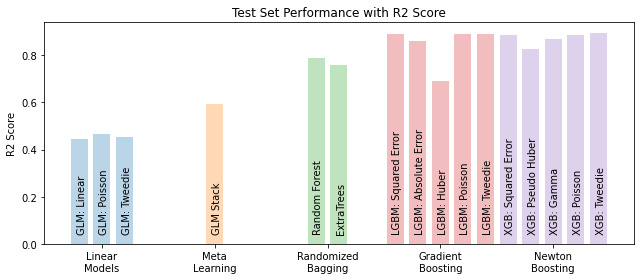

In [20]:
groups = {'Linear\nModels': ['GLM: Linear', 'GLM: Poisson', 'GLM: Tweedie'],
          'Meta\nLearning': ['GLM Stack'],
          'Randomized\nBagging': ['Random Forest', 'ExtraTrees'],
          'Gradient\nBoosting': ['LGBM: Squared Error', 'LGBM: Absolute Error', 
                                 'LGBM: Huber', 'LGBM: Poisson', 'LGBM: Tweedie'],
          'Newton\nBoosting': ['XGB: Squared Error', 'XGB: Pseudo Huber', 'XGB: Gamma',  'XGB: Poisson', 'XGB: Tweedie']}
          
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))   
# for j, metric in enumerate(['Test MAE', 'Test MSE', 'Test R2']):
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))   
for j, metric in enumerate(['Test R2']):
    for i, (methods, group) in enumerate(groups.items()):
        yy = results[results.Method.isin(group)][metric].values
        xx = i + (np.arange(0, len(yy)) - np.median(np.arange(0, len(yy)))) * 0.2
        ax.bar(xx, yy, width=0.15, alpha=0.3)
        for k in range(len(group)):
            ax.text(xx[k]-0.025, 0.05, group[k], rotation='vertical')           
ax.set_xticks(range(5))
ax.set_xticklabels(list(groups.keys()))
ax.set_ylabel('R2 Score');
ax.set_title('Test Set Performance with R2 Score');

fig.tight_layout()
pngFile = './figures/CH07_F14_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0.05)